# Matching Sersic Profiles to Real Galaxy images

This notebook is a demonstration on how to match Sersic profiles to real galaxy sources using slsim's CatalogSource class.
Matching is based off of:
1. axis ratio
2. physical size
3. n_sersic (optional, needs to be set with match_n_sersic=True when initializing the Source class)

The matched source is then rotated and scaled to match the desired Sersic angle and angular size.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.Lenses.lens import Lens
from slsim.ImageSimulation.image_simulation import sharp_image

import warnings

warnings.filterwarnings("ignore")

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Catalog: https://cosmos2025.iap.fr/catalog.html
# Paper: https://www.aanda.org/articles/aa/abs/2025/12/aa55799-25/aa55799-25.html
# This directory should contain the master catalog and the detection_images
cosmos_web_path = "/home/ahuang314/COSMOS_WEB"

# Catalog: https://zenodo.org/records/3242143
hst_cosmos_path = "/home/ahuang314/COSMOS_23.5_training_sample"

# arbitrary mag zero point
m_zp = 25


# Define a helper function
def simulate_images(source_dict):
    source1 = Source(
        extended_source_type="single_sersic",
        cosmo=cosmo,
        **source_dict,
    )
    source2 = Source(
        extended_source_type="catalog_source",
        catalog_path=cosmos_web_path,
        catalog_type="COSMOS_WEB",
        match_n_sersic=False,
        cosmo=cosmo,
        **source_dict,
    )

    source3 = Source(
        extended_source_type="catalog_source",
        catalog_path=hst_cosmos_path,
        catalog_type="HST_COSMOS",
        match_n_sersic=True,
        cosmo=cosmo,
        **source_dict,
    )

    # dummy, zero‑mass deflector
    deflector = Deflector(
        deflector_type="EPL",
        **{
            "z": 0.5,  # keep same redshift
            "theta_E": 0.0,  # zero mass
            "e1_light": 0.0,
            "e2_light": 0.0,
            "e1_mass": 0.0,
            "e2_mass": 0.0,
            "gamma_pl": 2.0,
            "angular_size": 0.05,  # [arcsec] any small value
            "n_sersic": 1.0,  # shape index
            "mag_g": 99.0,
            "mag_r": 99.0,
            "mag_i": 99.0,
            "mag_z": 99.0,
            "mag_y": 99.0,
        },
    )

    lens_class1 = Lens(
        source_class=source1,
        deflector_class=deflector,
        cosmo=cosmo,
    )
    lens_class2 = Lens(
        source_class=source2,
        deflector_class=deflector,
        cosmo=cosmo,
    )

    lens_class3 = Lens(
        source_class=source3,
        deflector_class=deflector,
        cosmo=cosmo,
    )

    pixscale = 0.03
    num_pix = int(source_dict["angular_size"] / pixscale * 4)

    image_list = []

    # simulate source‑only image
    # sersic
    image_list.append(
        sharp_image(
            lens_class=lens_class1,
            band="i",
            mag_zero_point=m_zp,
            num_pix=num_pix,
            delta_pix=pixscale,
            with_source=True,
            with_deflector=False,
        )
    )

    # cosmos web
    image_list.append(
        sharp_image(
            lens_class=lens_class2,
            band="i",
            mag_zero_point=m_zp,
            num_pix=num_pix,
            delta_pix=pixscale,
            with_source=True,
            with_deflector=False,
        )
    )

    # hst cosmos
    image_list.append(
        sharp_image(
            lens_class=lens_class3,
            band="i",
            mag_zero_point=m_zp,
            num_pix=num_pix,
            delta_pix=pixscale,
            with_source=True,
            with_deflector=False,
        )
    )

    lens_classes = [lens_class1, lens_class2, lens_class3]
    return image_list, lens_classes

In [3]:
def plot_images(image_list):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    title = ["Simulated Sersic", "Matched COSMOSWeb", "Matched HST COSMOS"]

    for i in range(len(ax)):
        im = ax[i].imshow(image_list[i], origin="lower")
        ax[i].set_title(title[i])
        plt.colorbar(im, ax=ax[i])
        #if i == 0:
        #    clim = im.get_clim()
        #if i == 1:
        #    im.set_clim(clim)

    plt.tight_layout()
    plt.show()

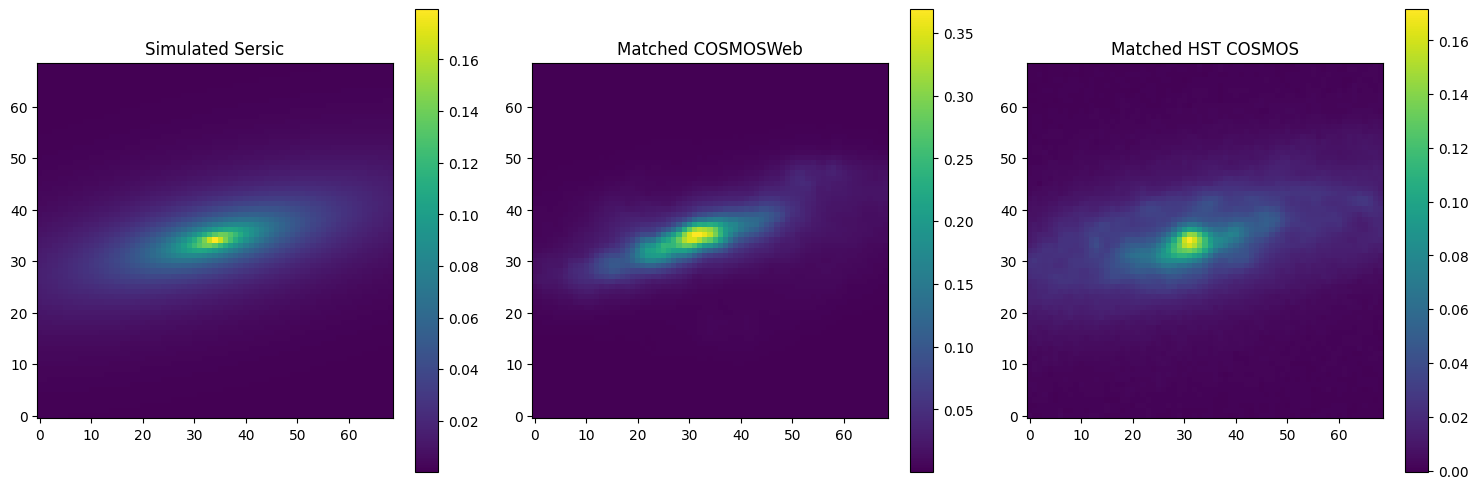

In [20]:
# build source dict for SLSIM
source_dict = {
    "z": 0.5,
    "mag_i": 20.3,
    "n_sersic": 1.4,
    "angular_size": 0.52,  # arcseconds
    "e1": -0.49697001616620306,
    "e2": 0.240998265256000574,
    "center_x": 0.0,
    "center_y": 0.0,
}

image_list, lens_classes = simulate_images(source_dict)
plot_images(image_list)

Many of the COSMOSWeb sources are poorly described by a Sersic model which can lead to some weird matches

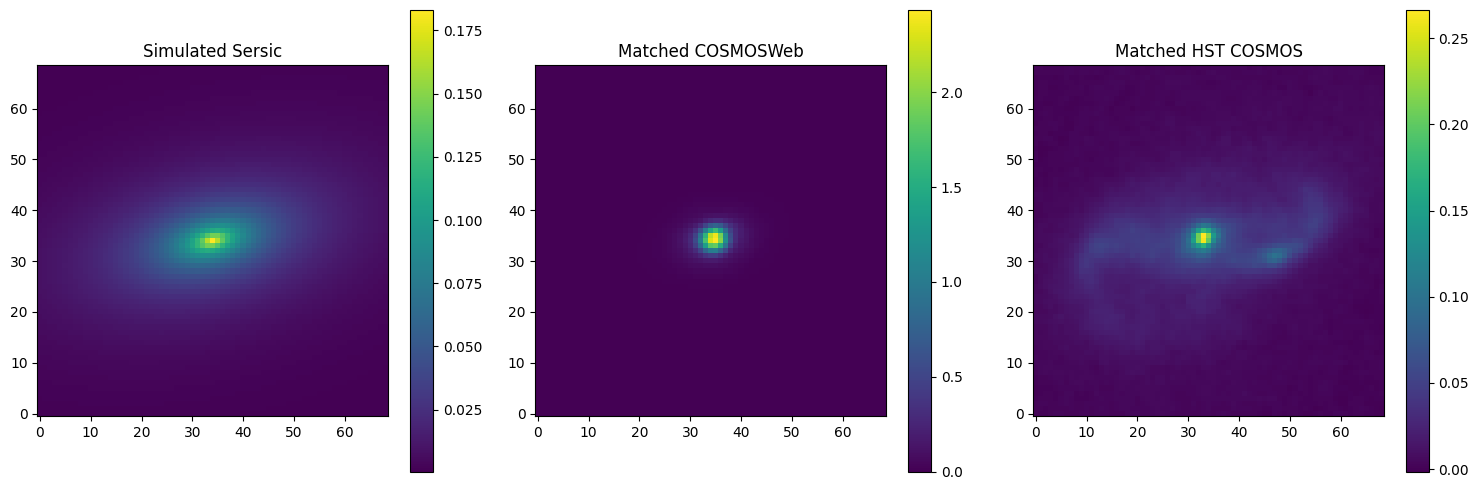

In [22]:
source_dict["e1"] = -0.29697001616620306
source_dict["e2"] = 0.140998265256000574

image_list, lens_classes = simulate_images(source_dict)
plot_images(image_list)

In [23]:
for image in image_list:
    print(np.sum(image))

61.01734381815431
75.64396161498402
63.00410738270676


# Display the properties of the matched sources

In [24]:
# cosmos web
id = lens_classes[1]._source[0]._source.galaxy_ID
cosmos_web_final_catalog = lens_classes[1]._source[0]._source.final_catalog
matched_source = cosmos_web_final_catalog[cosmos_web_final_catalog["id"] == id]
print("sersic fit reduced chi squared:", matched_source["sersic_fit_chi2"][0])
matched_source

sersic fit reduced chi squared: 1121.162353515625


<Table length=1>
  id    tile          ra        ...     axis_ratio       physical_size  
int64  bytes3      float64      ...      float64            float64     
------ ------ ----------------- ... ------------------ -----------------
232894     A7 149.8475026386801 ... 0.5024385055121452 3.260289587174789

In [25]:
# hst cosmos
id = lens_classes[2]._source[0]._source.galaxy_ID
hst_cosmos_final_catalog = lens_classes[2]._source[0]._source.final_catalog
matched_source = hst_cosmos_final_catalog[hst_cosmos_final_catalog["IDENT"] == id]
matched_source

<Table length=1>
IDENT           GAL_FILENAME           ...    sersic_index       sersic_angle   
int32             bytes32              ...      float64            float64      
----- -------------------------------- ... ------------------ ------------------
32982 real_galaxy_images_23.5_n52.fits ... 1.3368715872191301 1.6166951908142388

# Montage of images from the COSMOSWeb catalog

id: 5


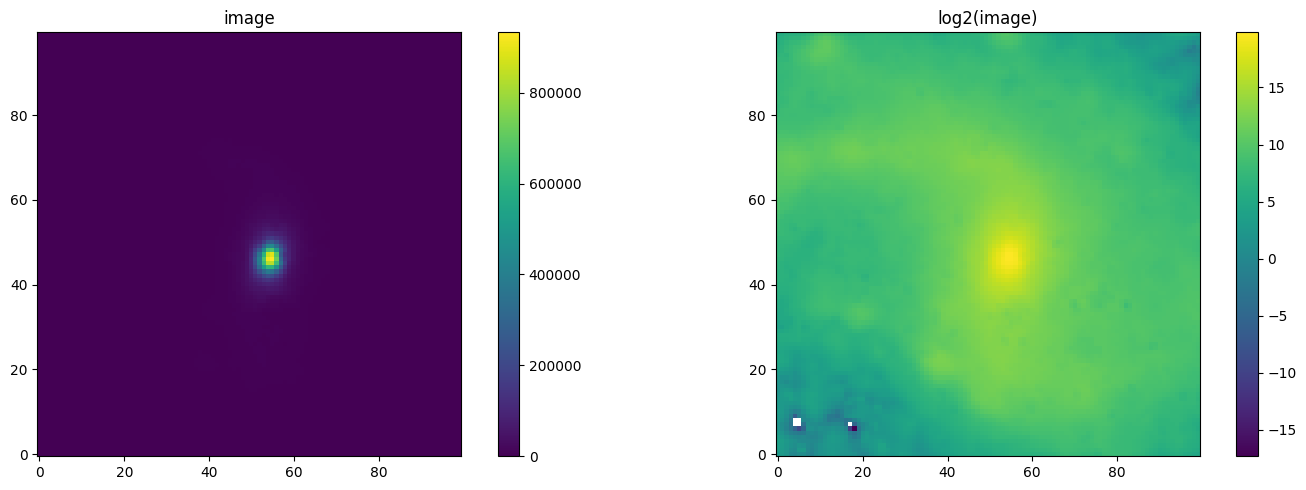

id: 286


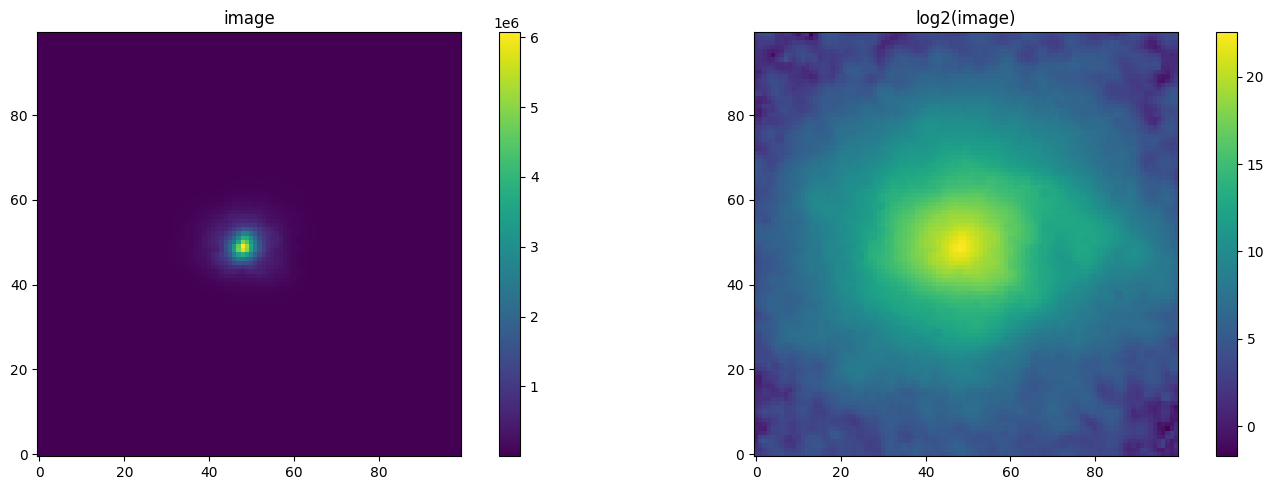

id: 360


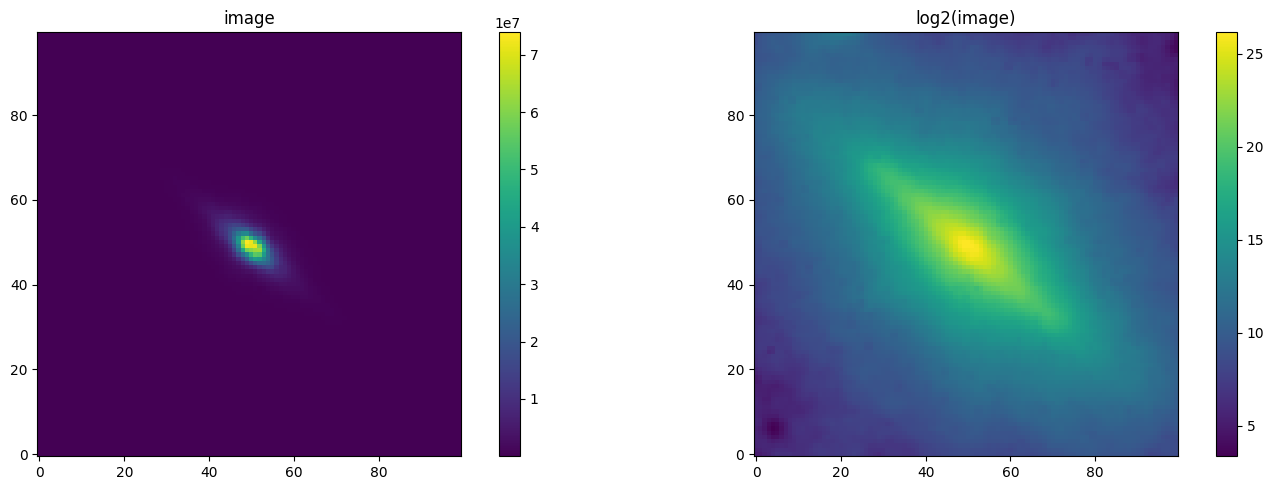

id: 361


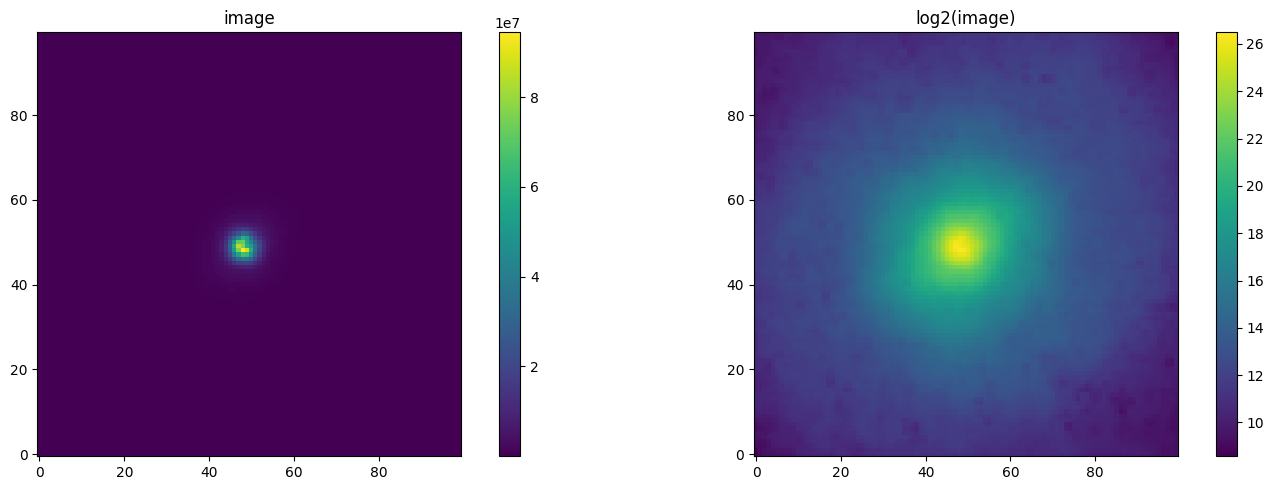

id: 364


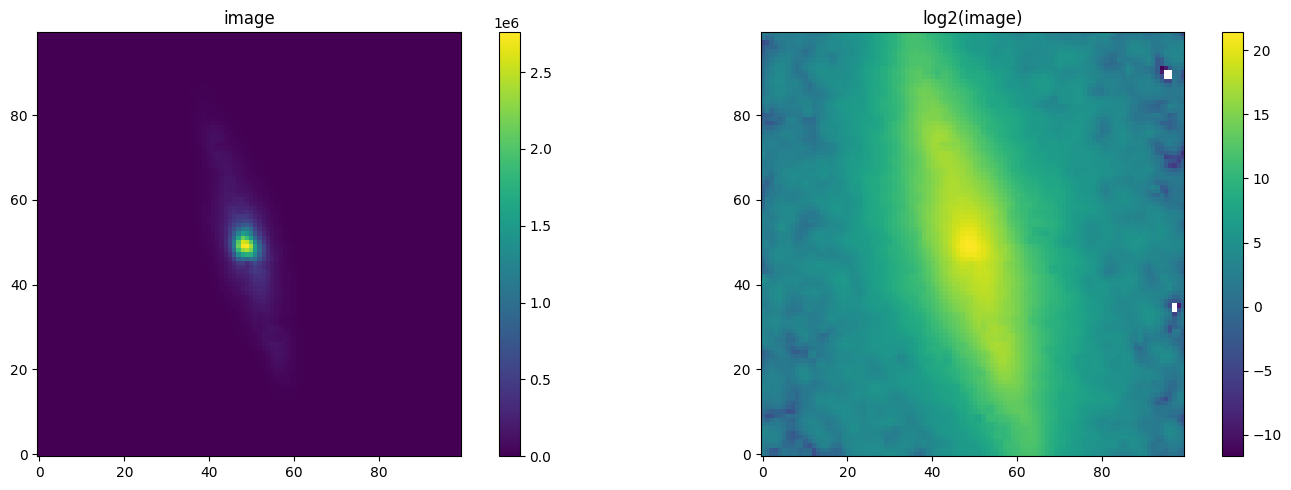

id: 780


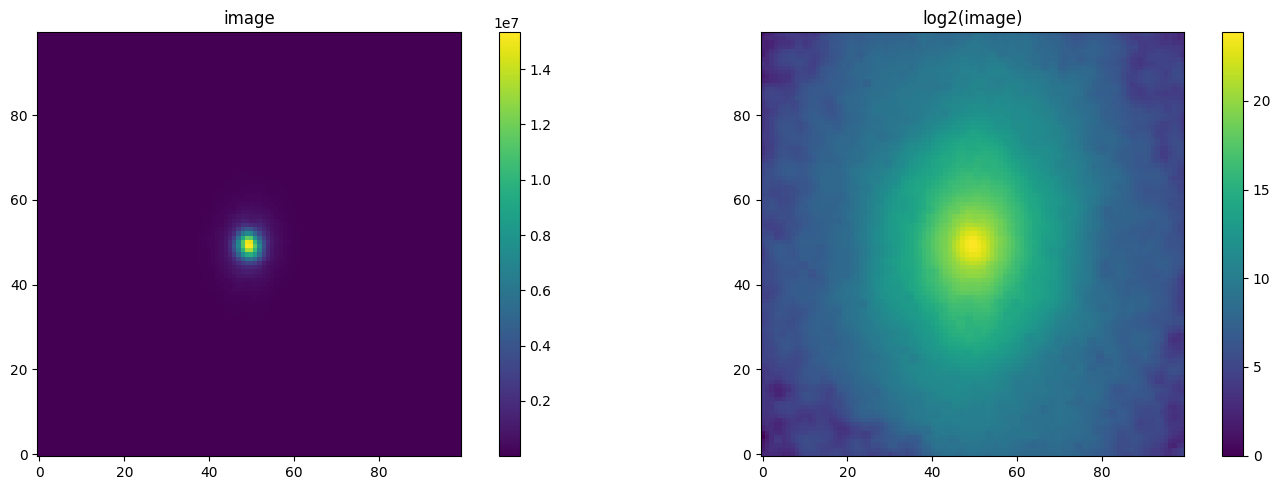

id: 884


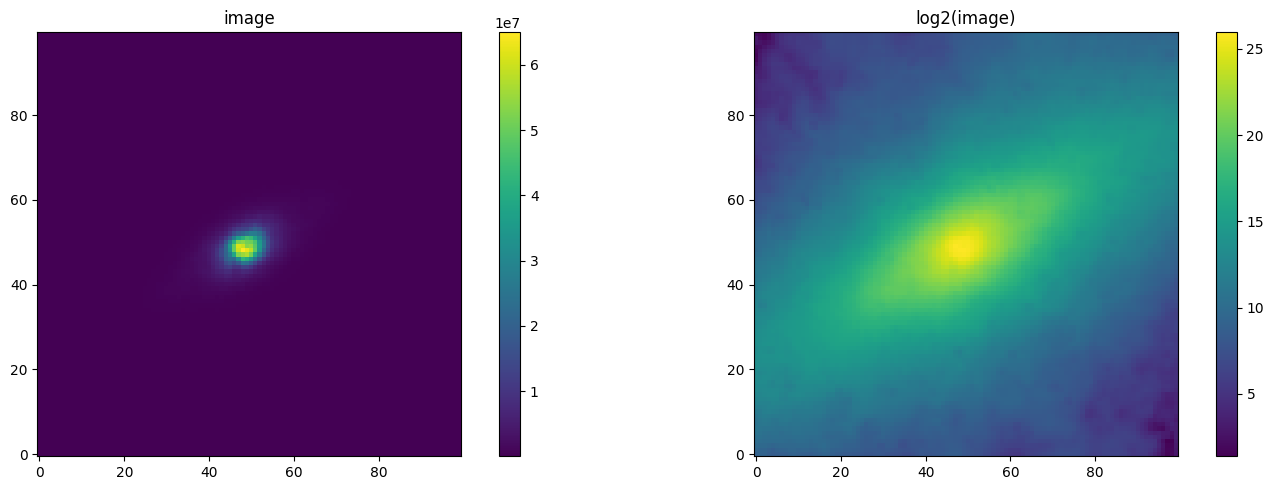

id: 1313


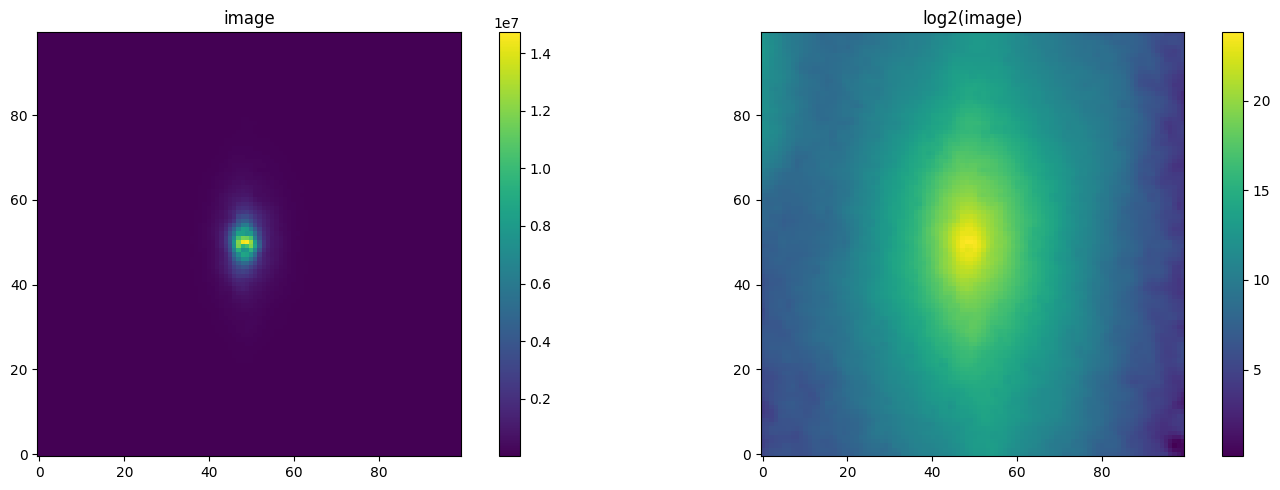

id: 1316


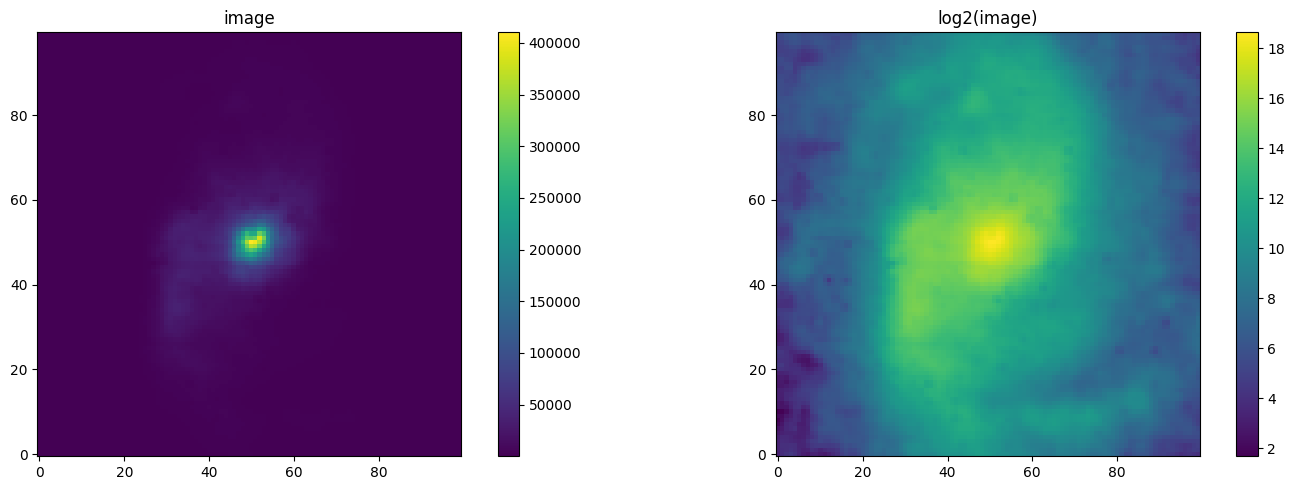

id: 1368


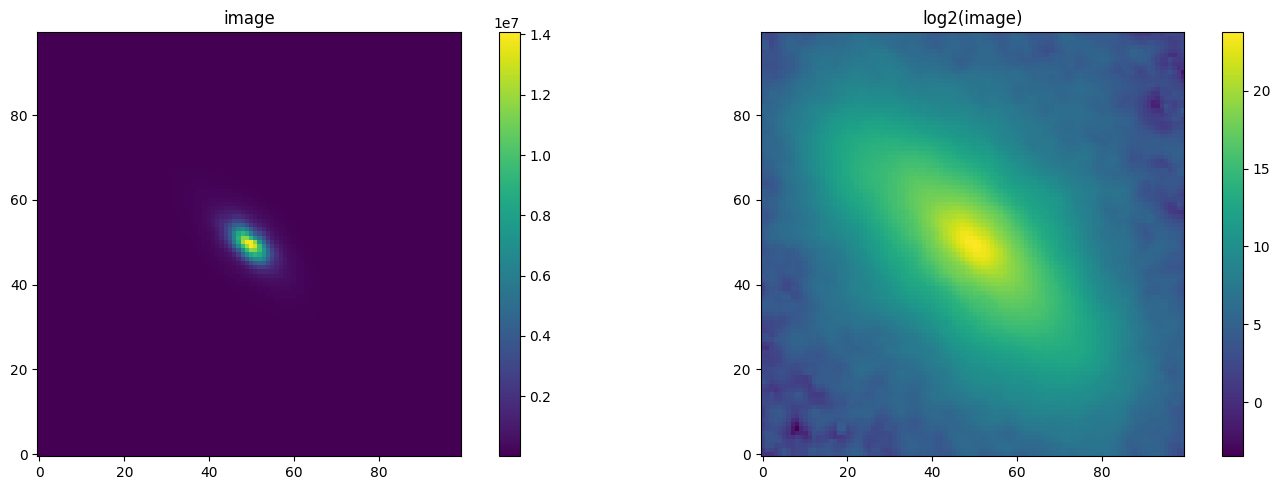

id: 1431


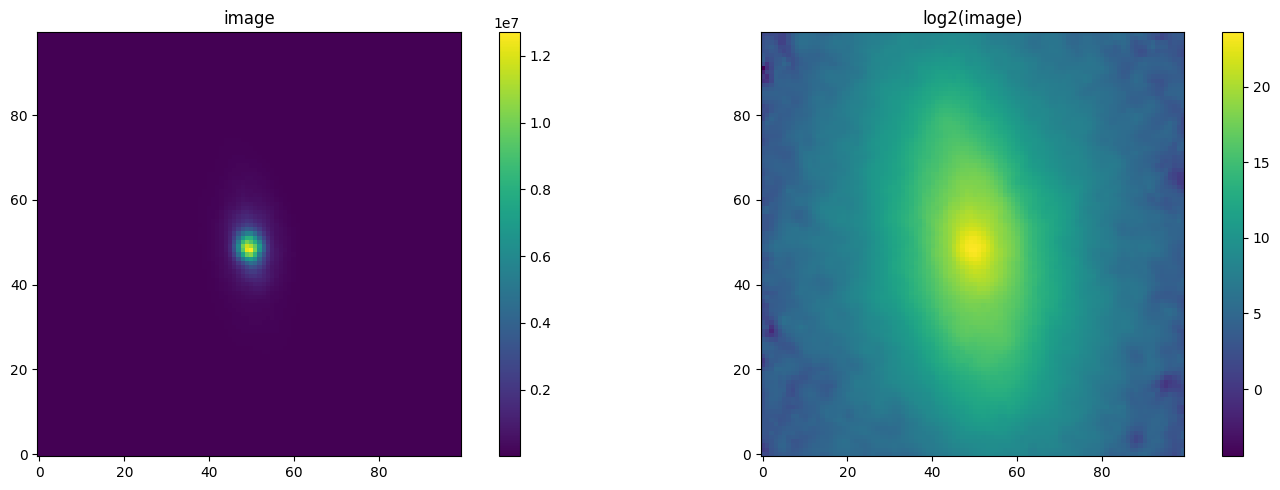

id: 2187


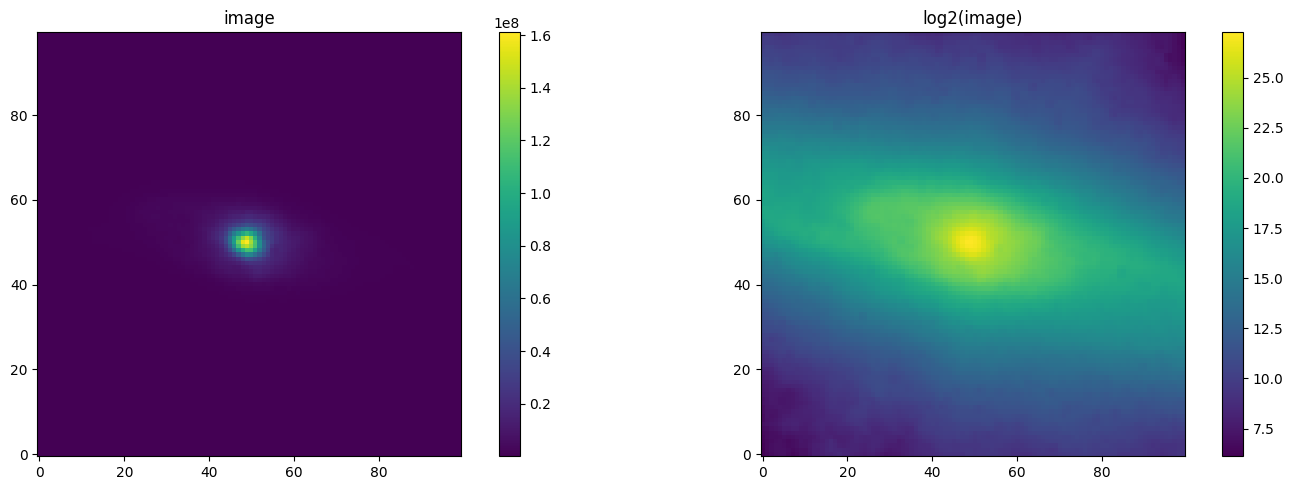

id: 2188


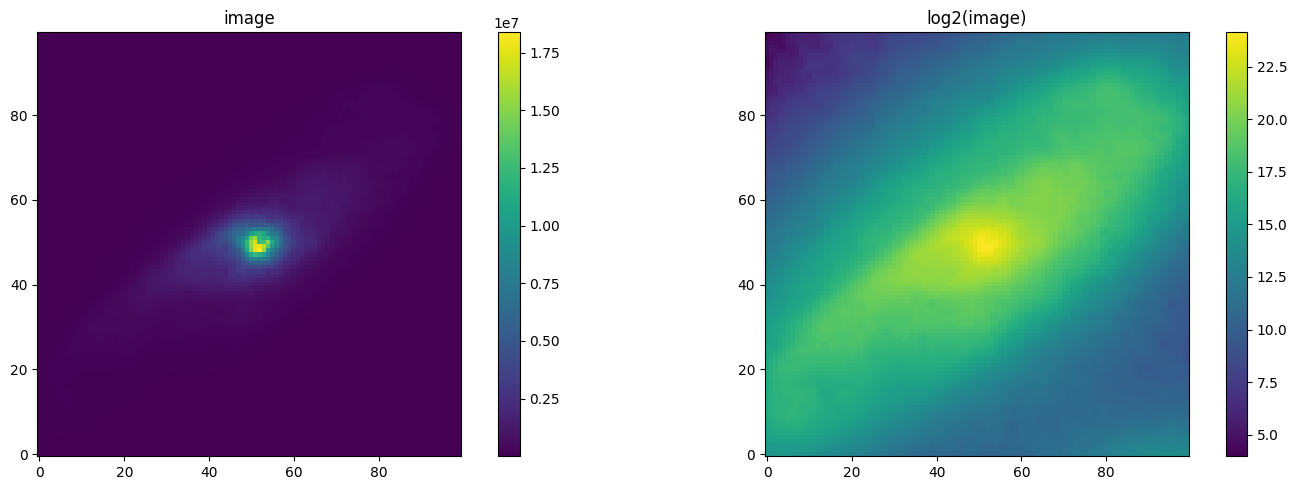

id: 3011


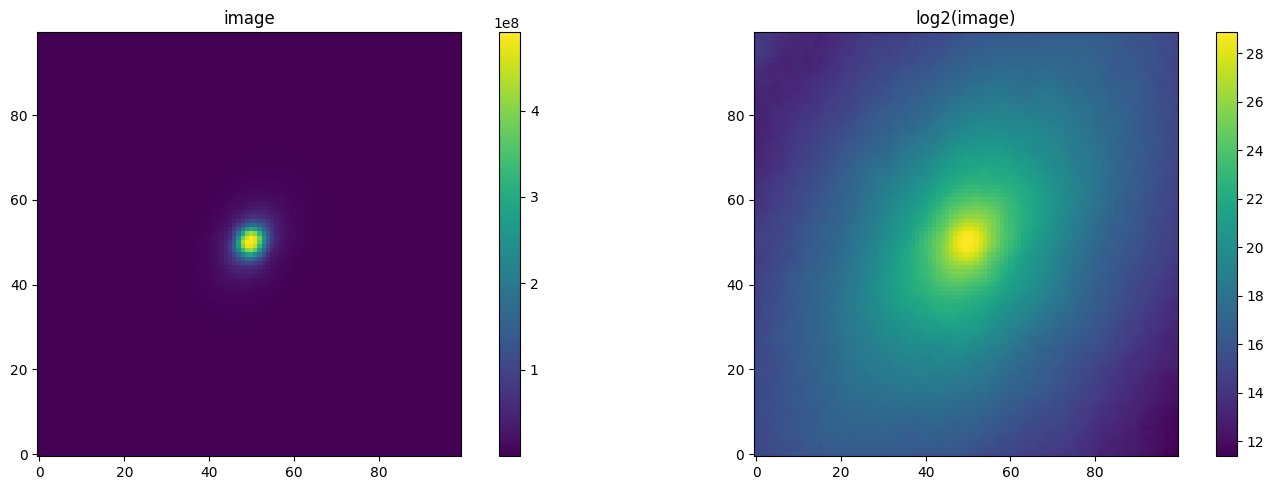

id: 3175


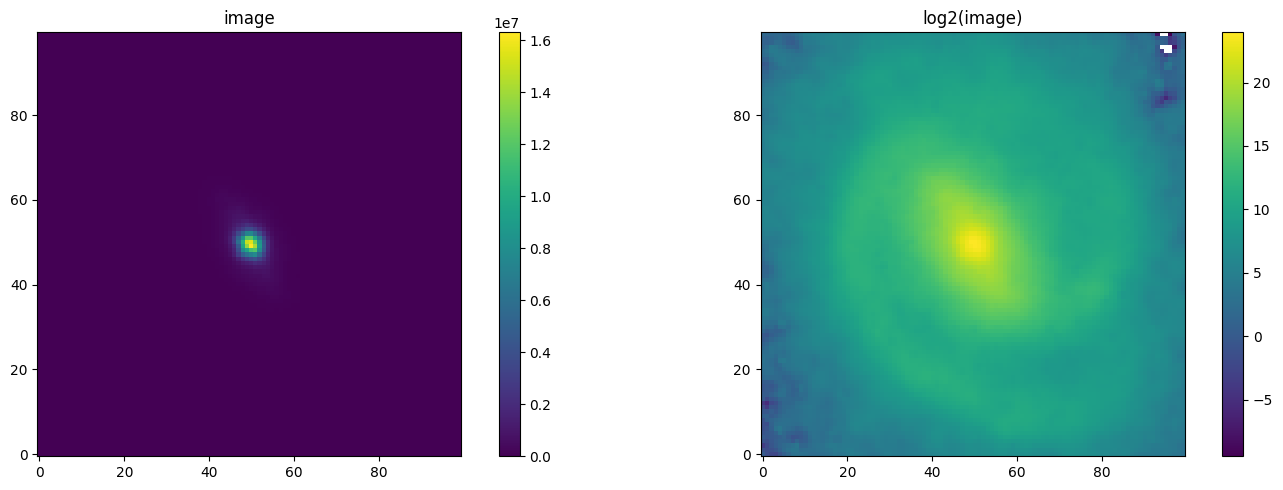

id: 3456


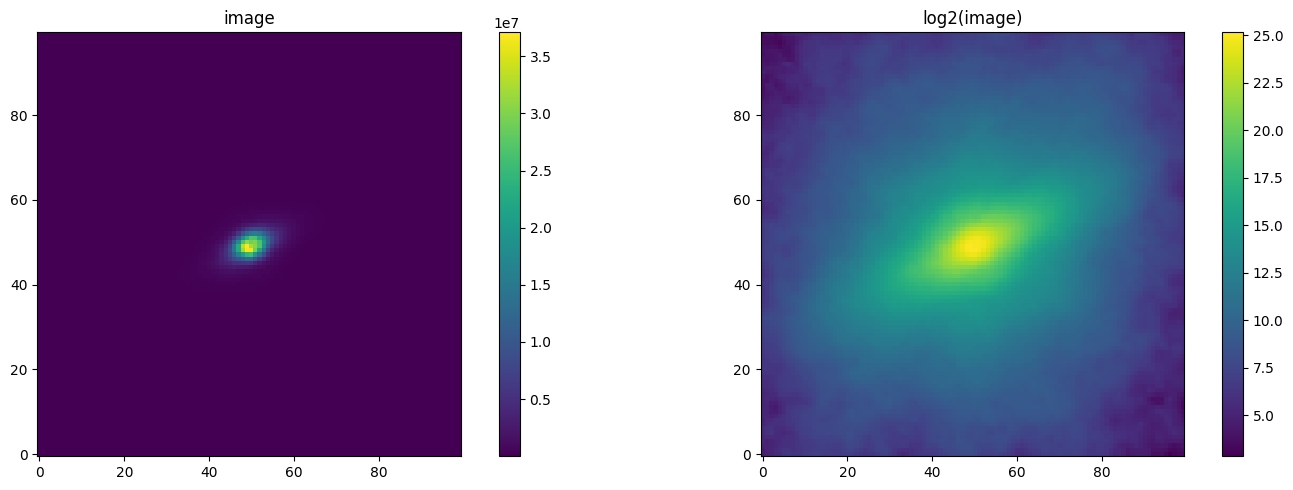

id: 3665


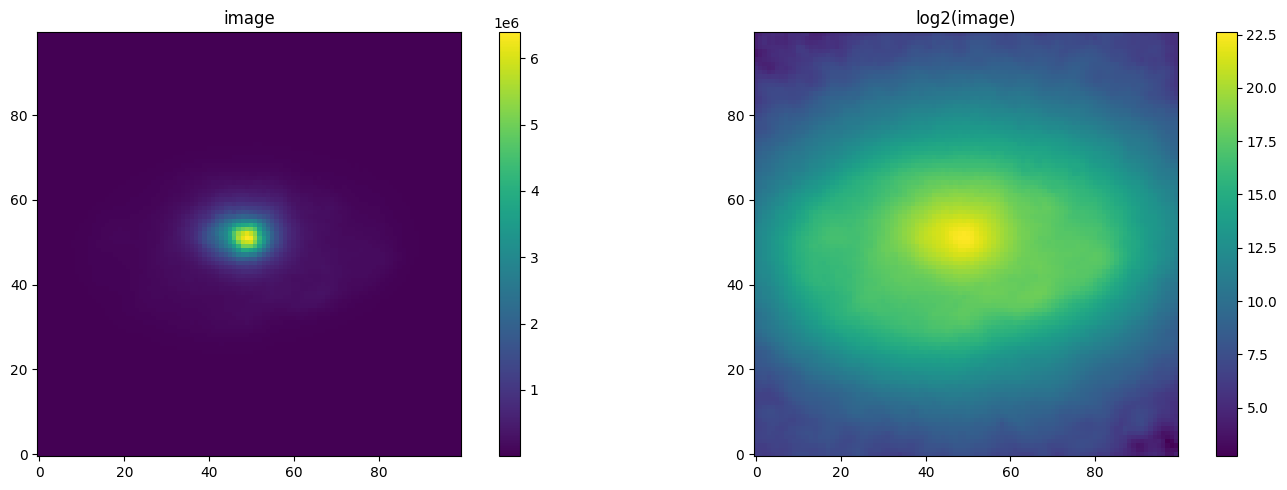

id: 3676


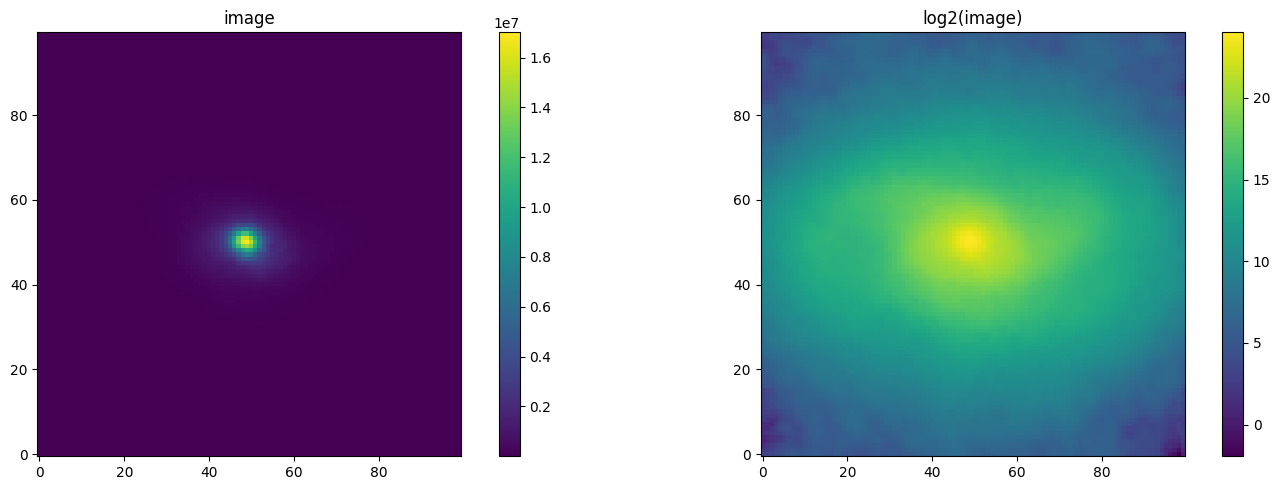

id: 3711


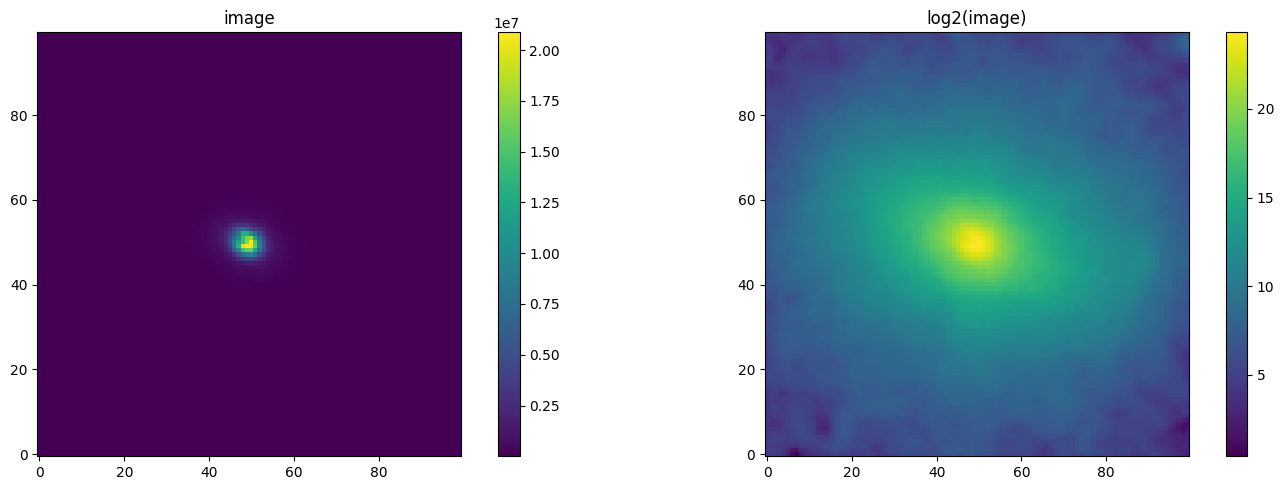

id: 4767


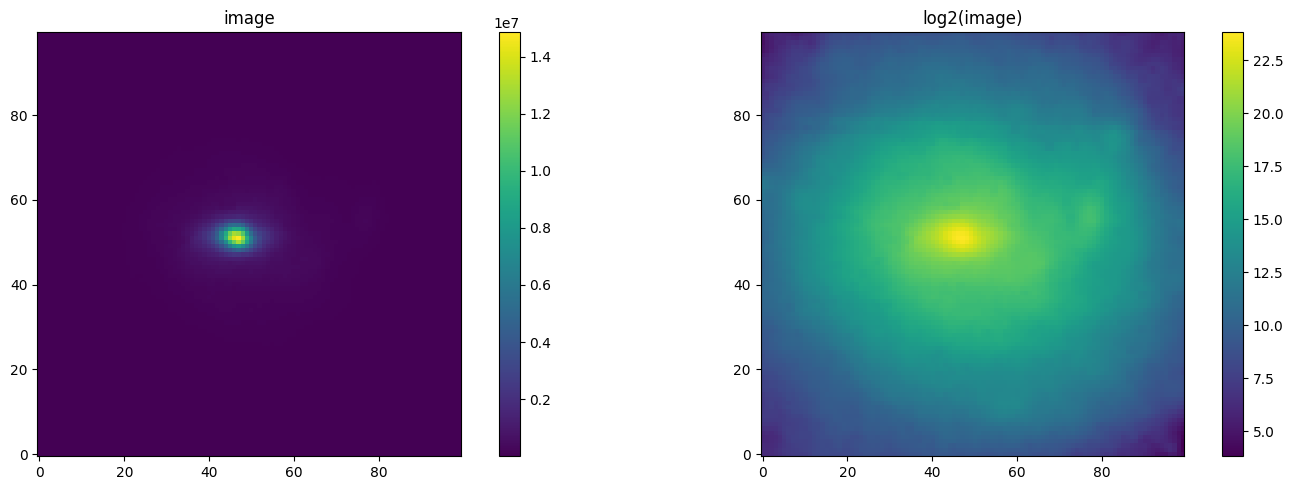

id: 4882


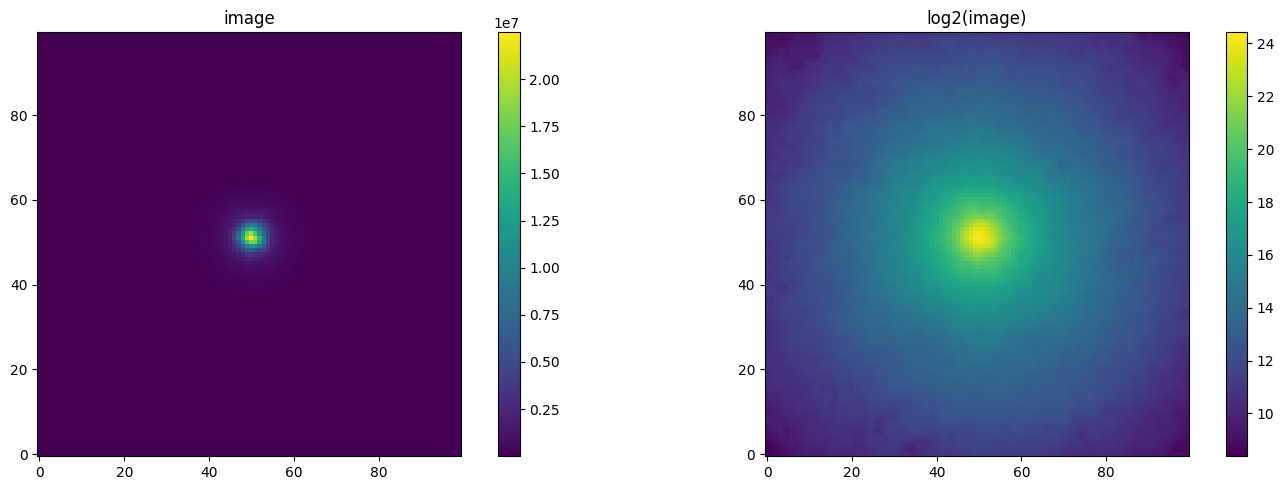

id: 5155


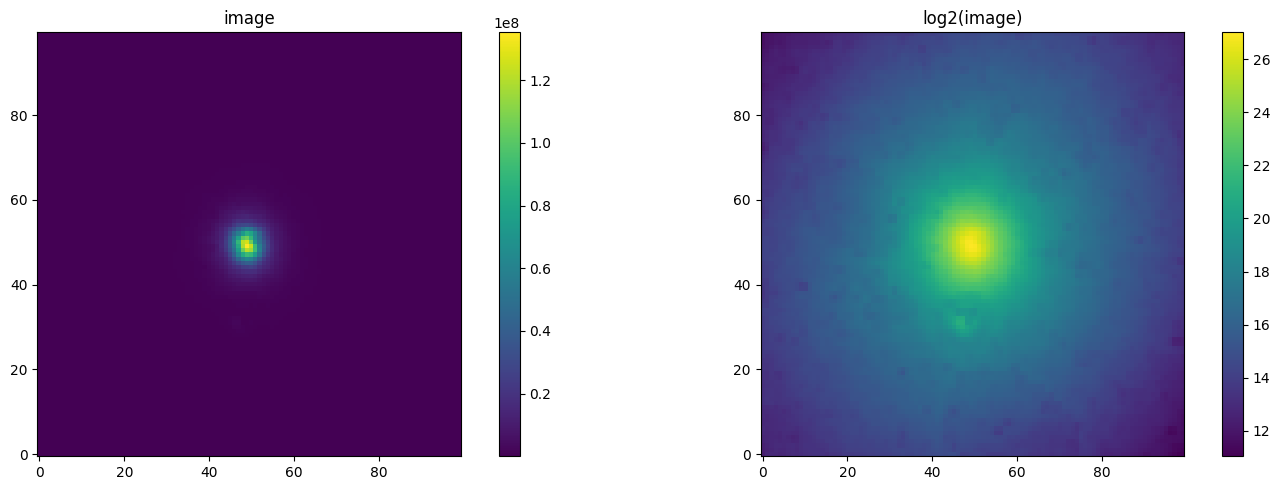

id: 5156


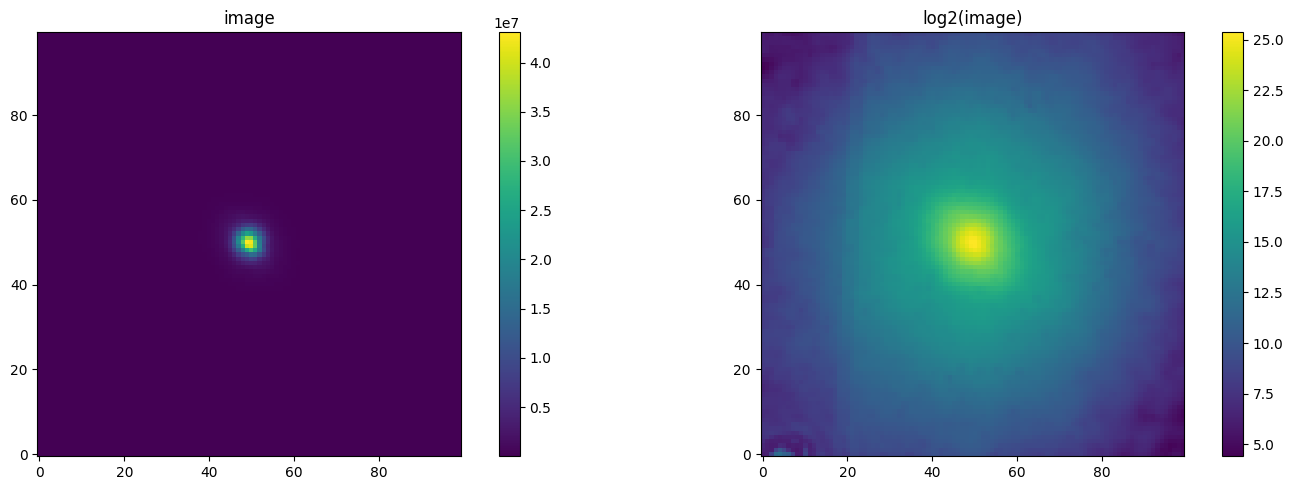

id: 5326


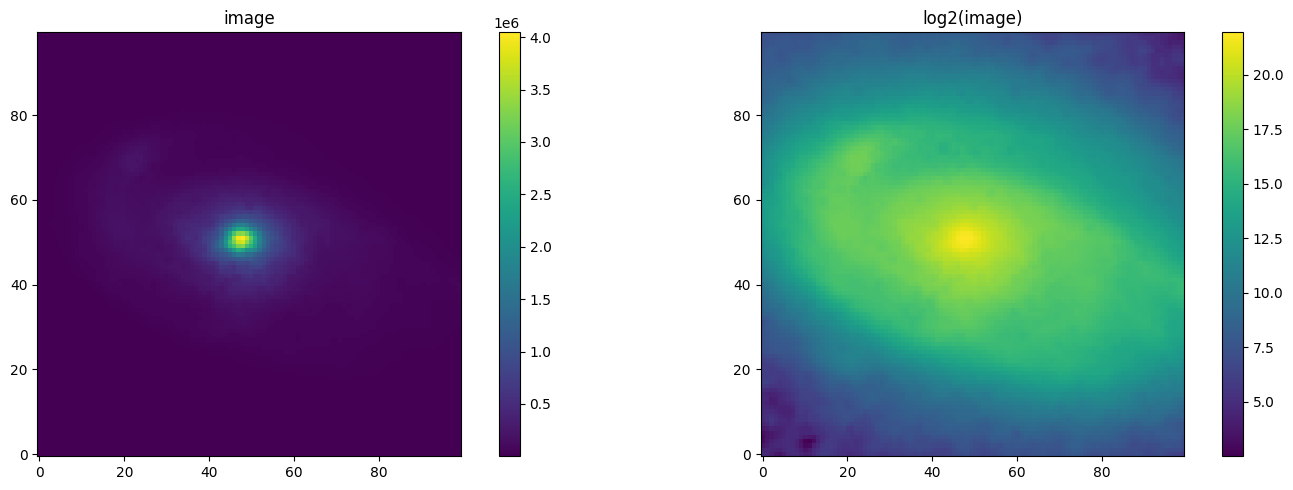

id: 5347


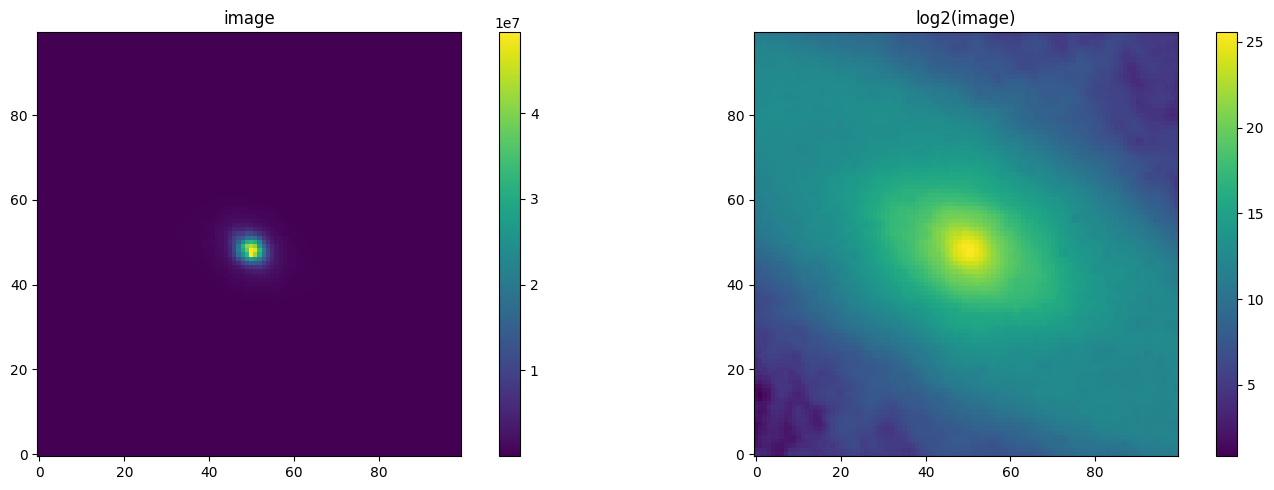

id: 5440


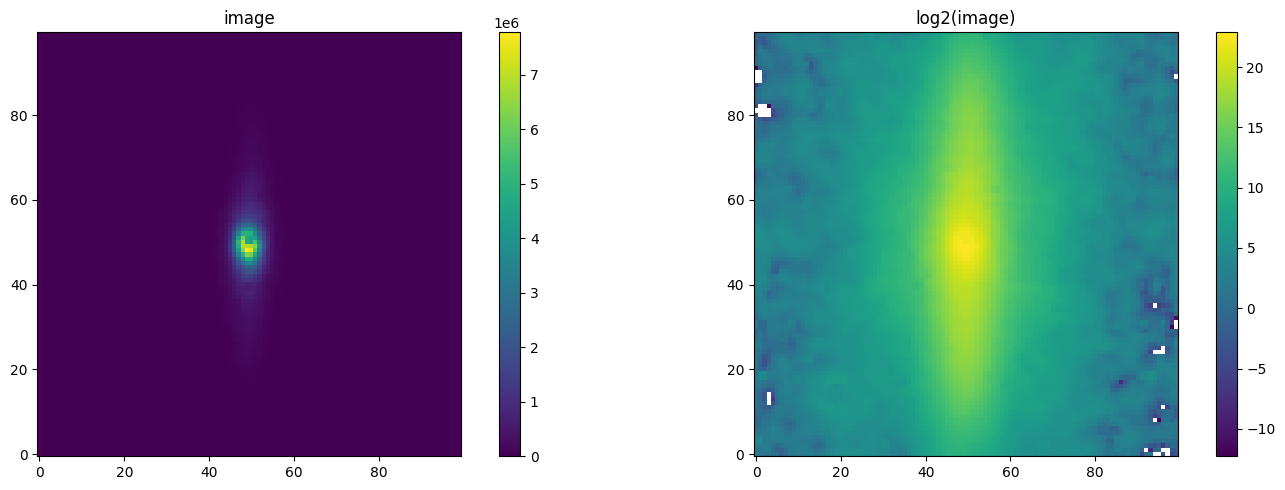

id: 5452


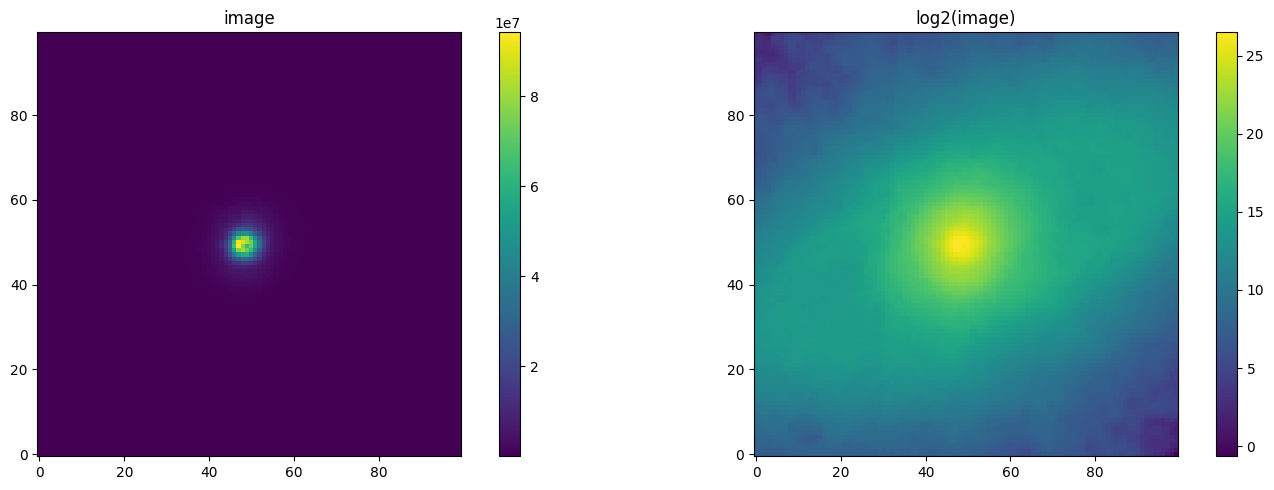

id: 5720


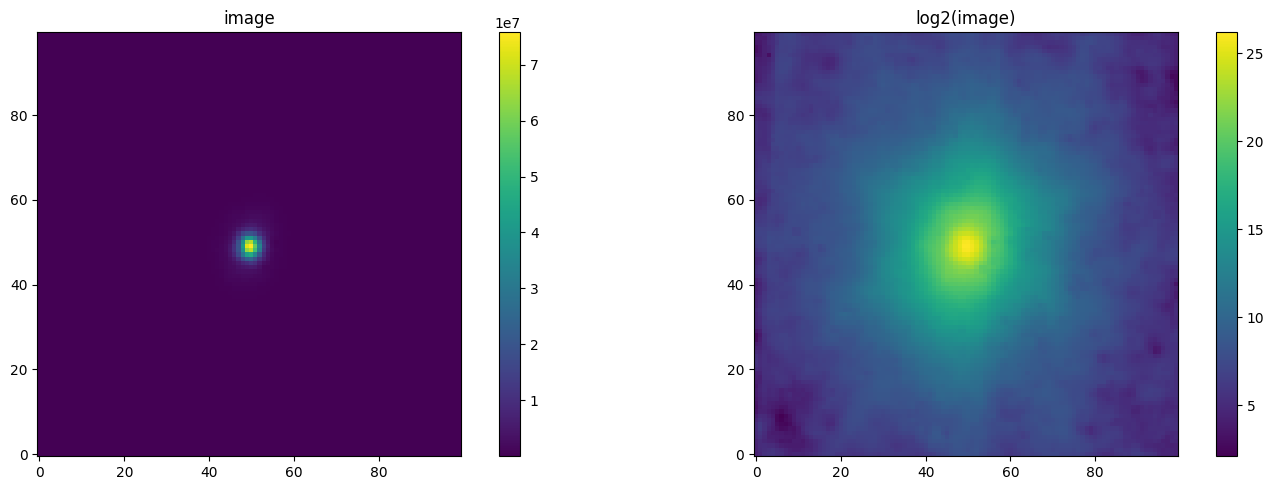

id: 6173


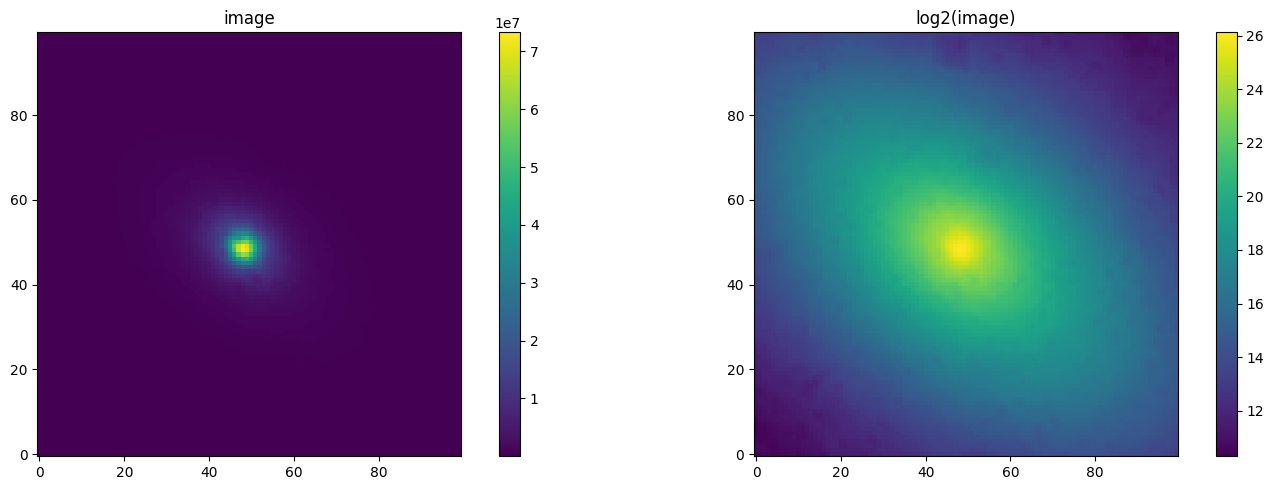

id: 6174


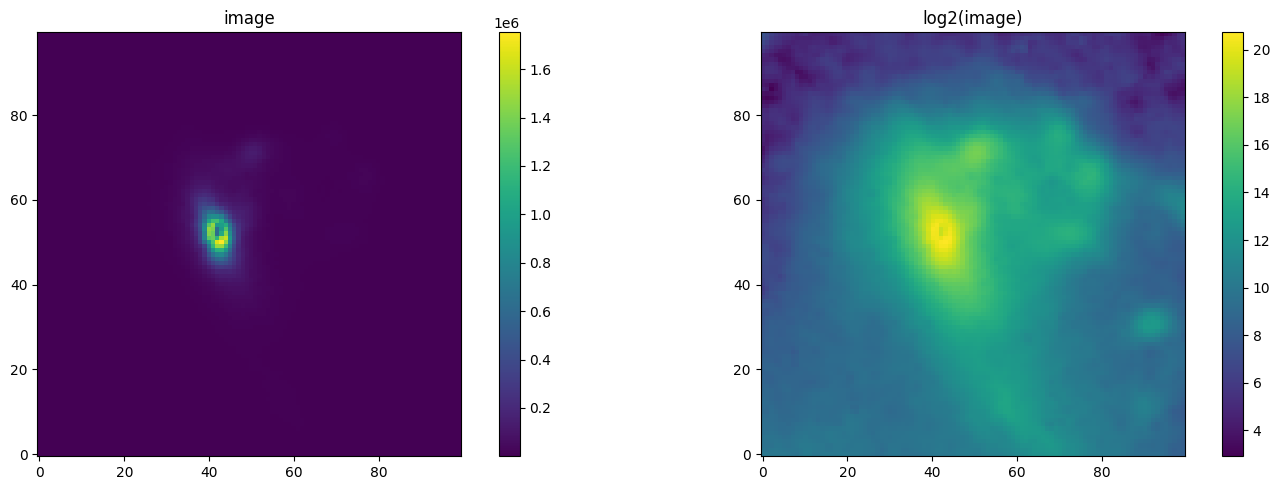

In [9]:
num_sources = 30
for source in cosmos_web_final_catalog[0:num_sources]:

    id = source["id"]
    tile = source["tile"]
    print(f"id: {id}")
    coords = SkyCoord(source["ra"], source["dec"], unit="deg")
    detection_file = (
        cosmos_web_path + f"/detection_images/detection_chi2pos_SWLW_{tile}.fits"
    )
    data = fits.getdata(detection_file)

    # Get WCS from the FITS header
    with fits.open(detection_file) as hdul:
        wcs = WCS(hdul[0].header)

    # Create cutout centered at coords
    size = (100, 100)  # size in pixels (height, width)
    cutout = Cutout2D(data, coords, size, wcs=wcs)

    _, ax = plt.subplots(1, 2, figsize=(15, 5))

    im0 = ax[0].imshow(cutout.data, origin="lower")
    im1 = ax[1].imshow(np.log2(cutout.data), origin="lower")
    ax[0].set_title("image")
    ax[1].set_title("log2(image)")
    plt.colorbar(im0, ax=ax[0])
    plt.colorbar(im1, ax=ax[1])
    plt.tight_layout()
    plt.show()

# Montage of HST-COSMOS images

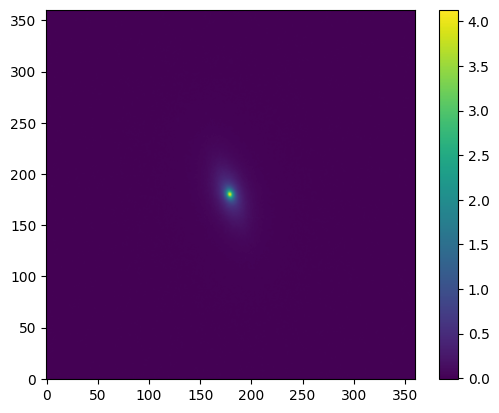

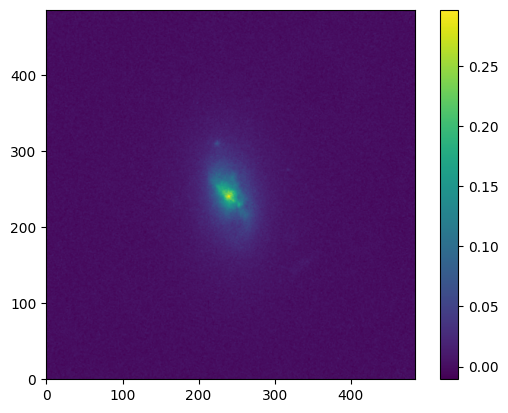

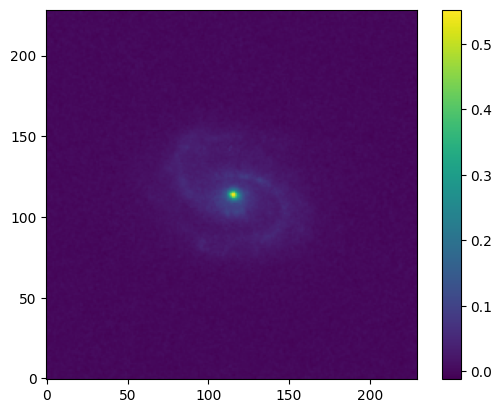

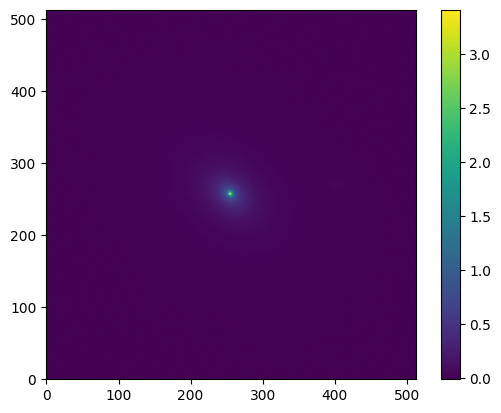

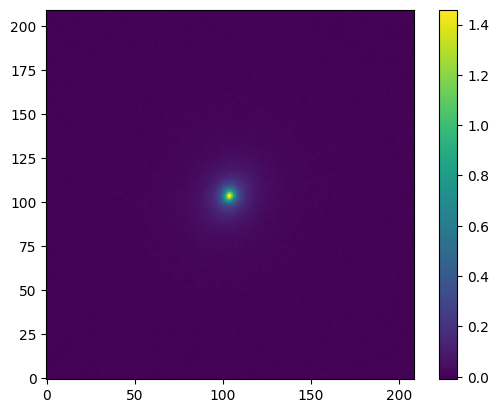

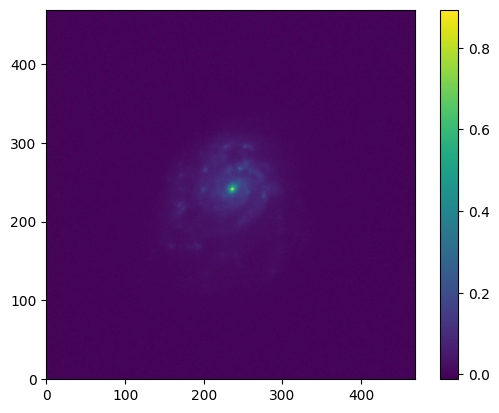

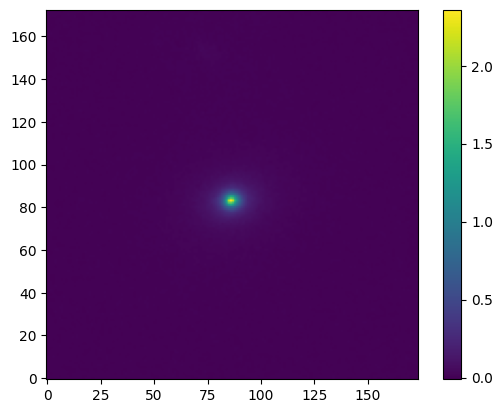

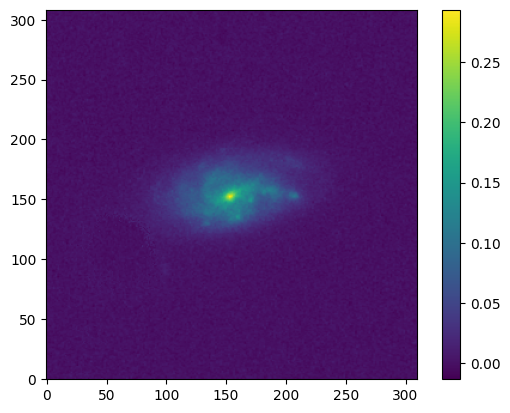

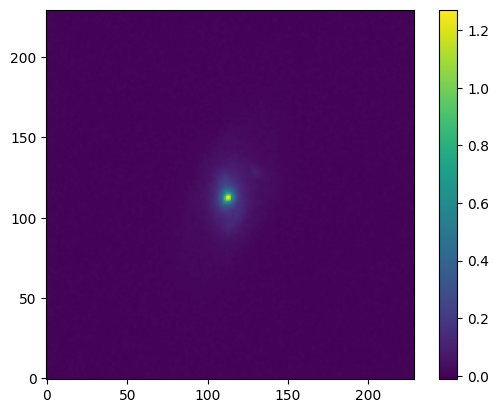

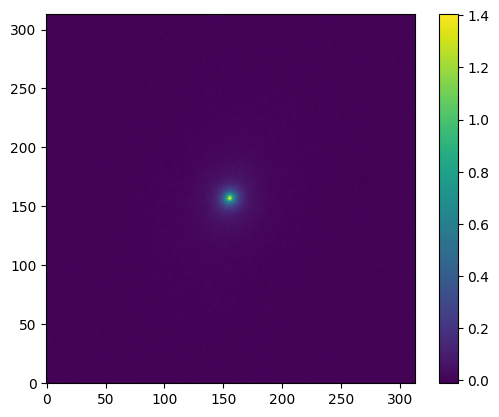

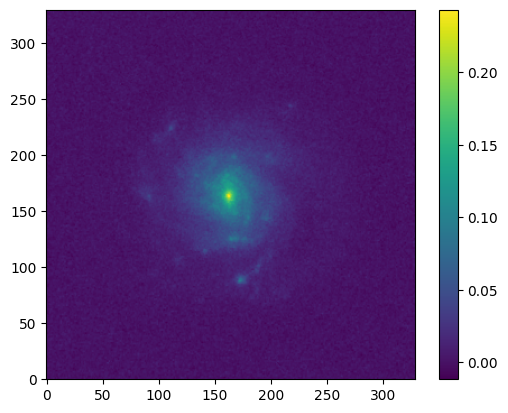

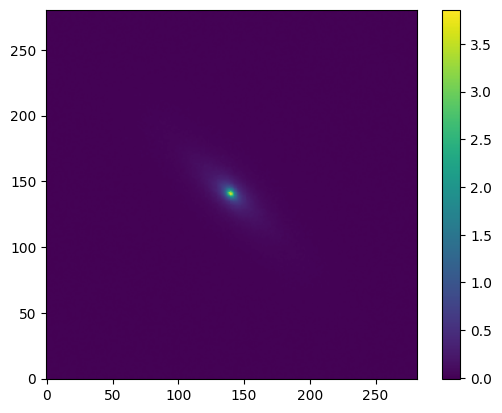

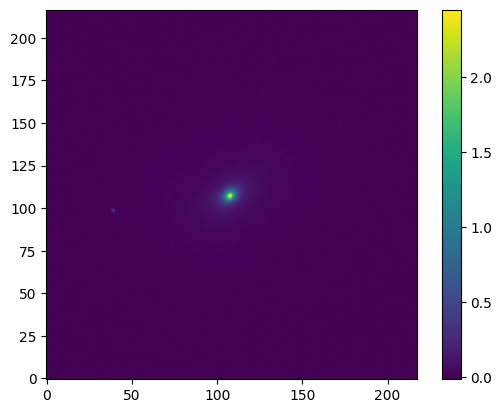

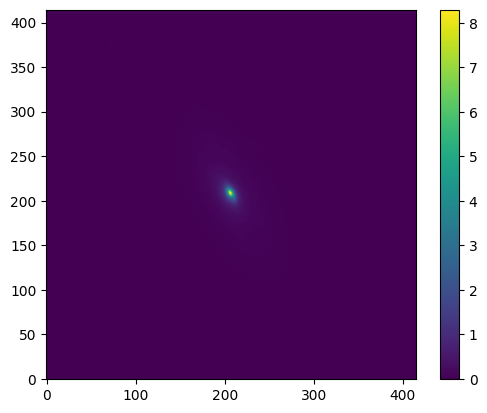

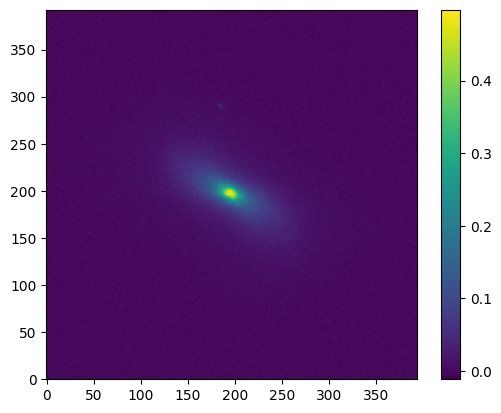

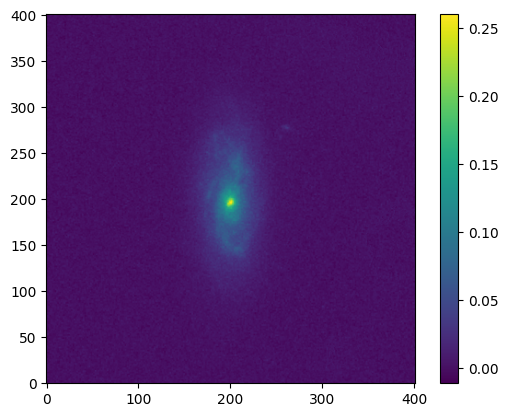

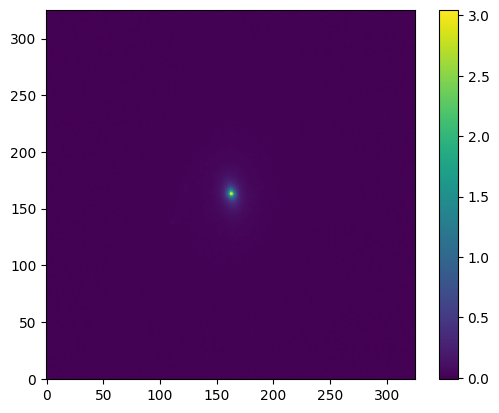

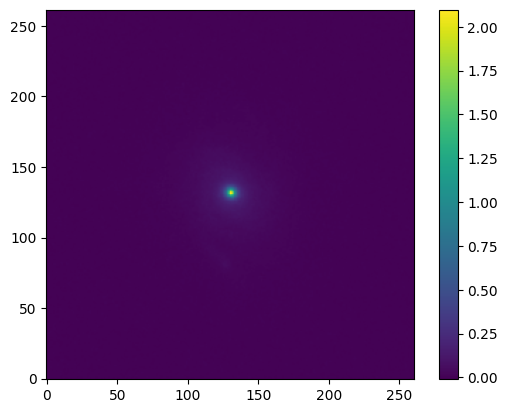

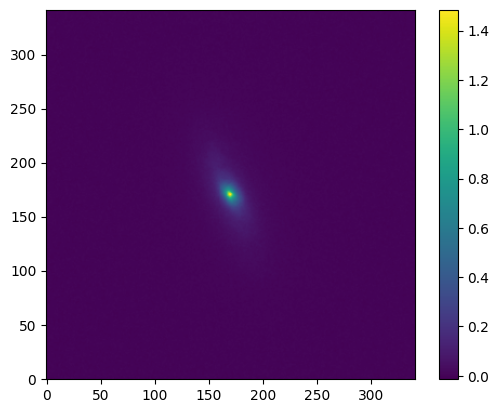

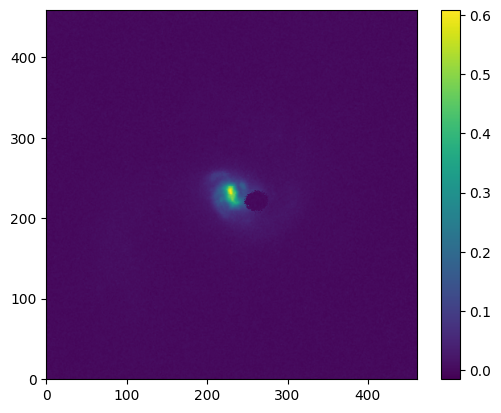

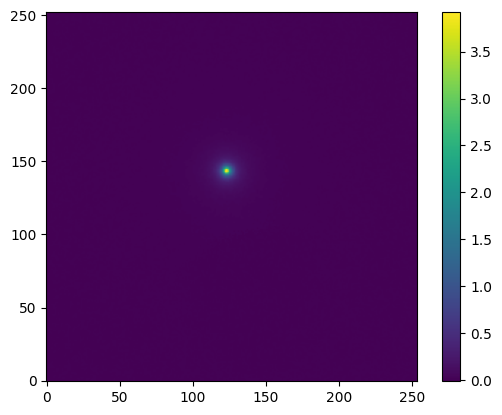

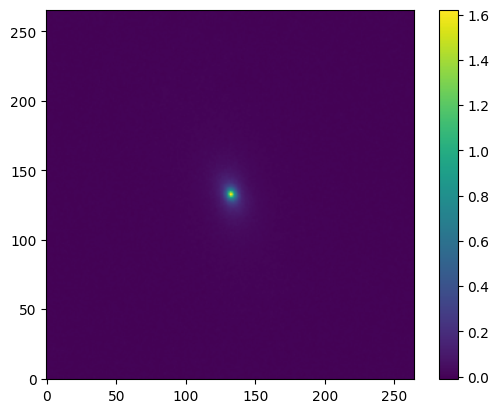

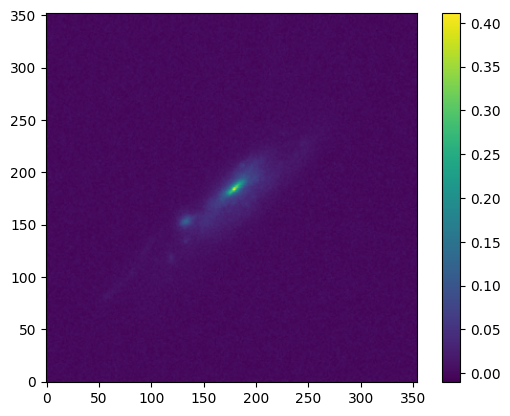

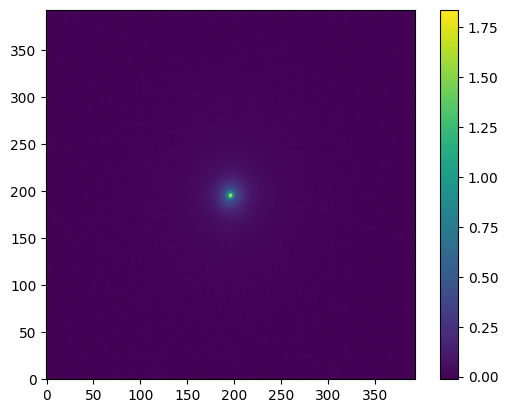

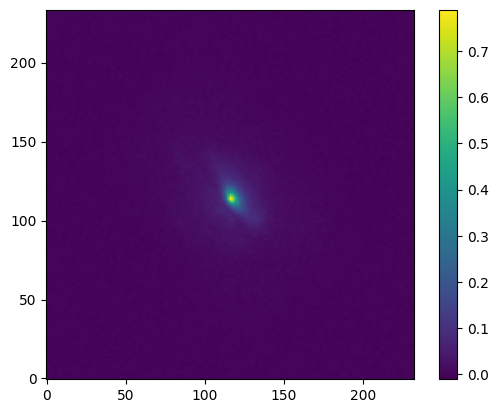

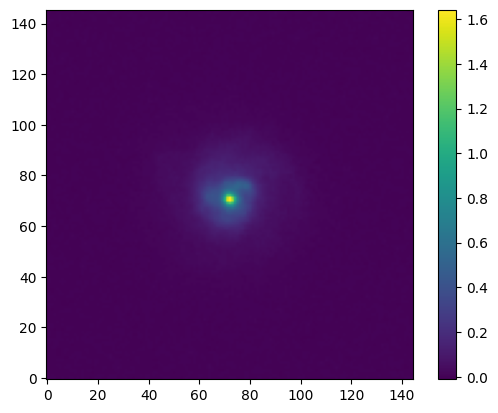

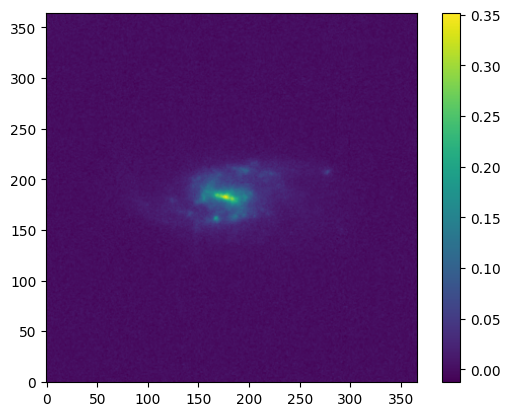

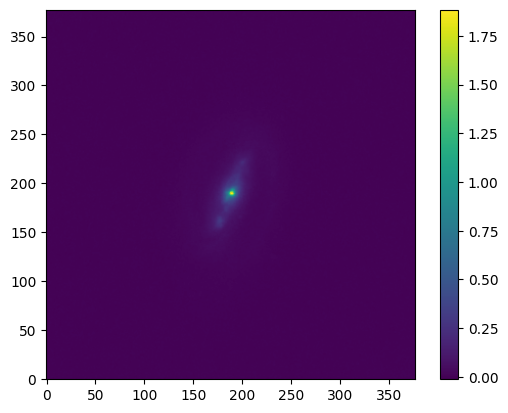

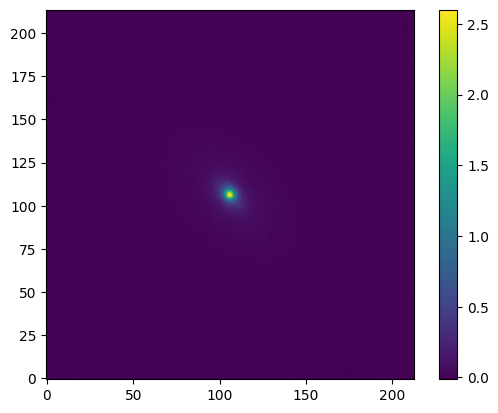

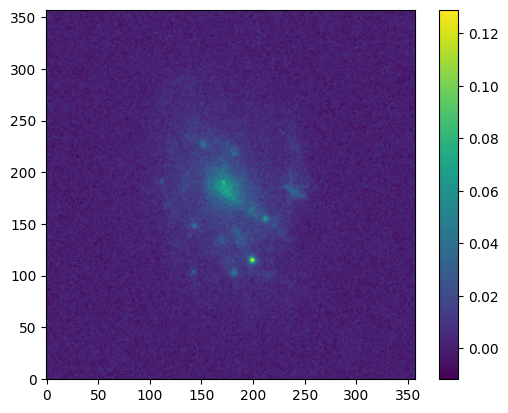

In [10]:
for source in hst_cosmos_final_catalog[0:num_sources]:

    fname = source["GAL_FILENAME"]
    hdu = int(source["GAL_HDU"])
    path = os.path.join(hst_cosmos_path, fname)
    with fits.open(path) as file:
        image = file[hdu].data  # flux per pixel

    plt.imshow(image, origin="lower")
    plt.colorbar()
    plt.show()